# HOME LOAN APPROVAL PREDICTION 
EDA & Multple Linear Regression & Lasso Regression

---

*Shiying Cai, Xixiang Liu, Paru Meyyappan, Willy Lan*

In [ ]:
# Connect your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive
# !ls # special shell command to view the files in the home directory of the notebook environment

Mounted at /content/gdrive
/content/gdrive/MyDrive


# set up

## Import packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Import files

In [ ]:
df = pd.DataFrame(pd.read_csv("loan_sanction_train.csv"))
display(f"Observations in Dataset: {len(df)}")

'Observations in Dataset: 614'

In [ ]:
df.shape
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# EDA

In [ ]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


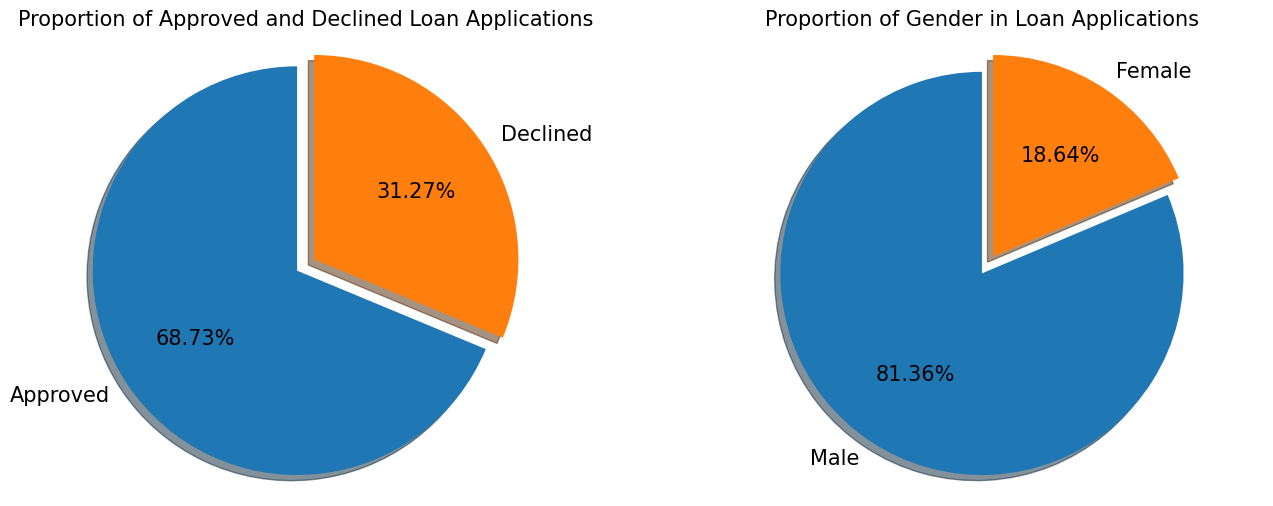

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first pie chart on the first subplot
labels1 = 'Approved', 'Declined'
sizes1 = df['Loan_Status'].value_counts()
explode1 = (0, 0.1)
ax1.pie(sizes1, explode=explode1, labels=labels1, autopct='%1.2f%%', textprops={'fontsize': 15},
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Proportion of Approved and Declined Loan Applications", size=15)
ax1.tick_params(labelsize=16)

# Plot the second pie chart on the second subplot
labels2 = 'Male', 'Female'
sizes2 = df['Gender'].value_counts()
explode2 = (0, 0.1)
ax2.pie(sizes2, explode=explode2, labels=labels2, autopct='%1.2f%%', textprops={'fontsize': 15},
        shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title("Proportion of Gender in Loan Applications", size=15)
ax2.tick_params(labelsize=16)

# Show the plot
plt.show()


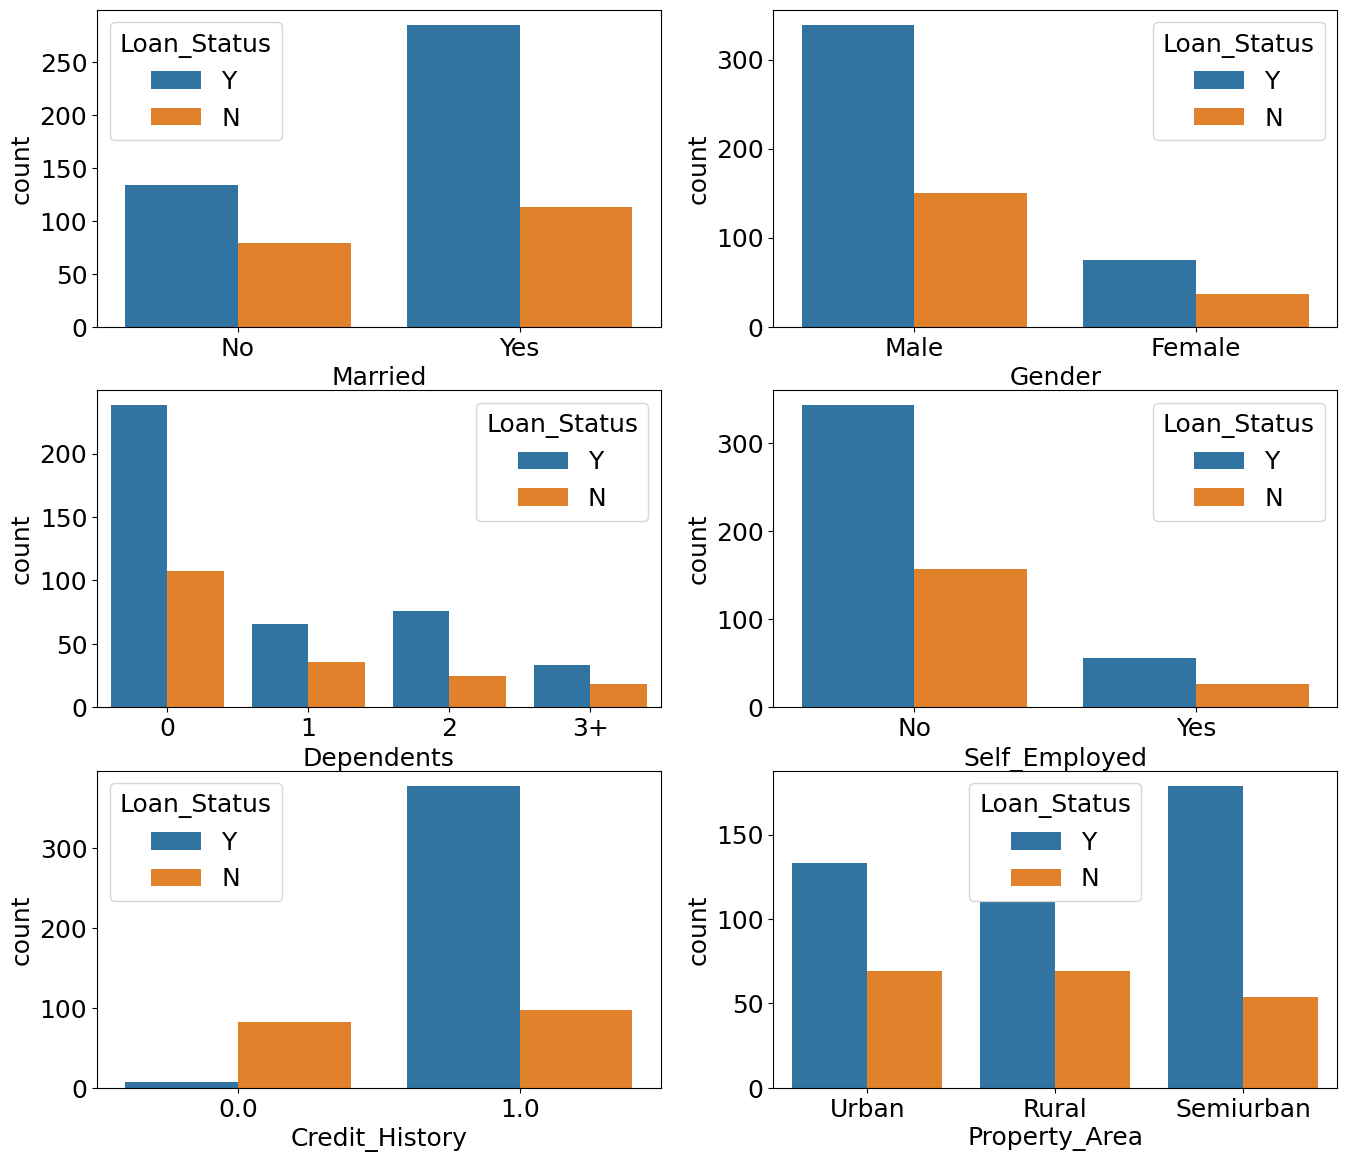

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(16, 14))
sns.countplot(x='Married', hue = 'Loan_Status',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Loan_Status',data = df, ax=axarr[0][1])
sns.countplot(x='Dependents', hue = 'Loan_Status',data = df, ax=axarr[1][0])
sns.countplot(x='Self_Employed', hue = 'Loan_Status',data = df, ax=axarr[1][1])
sns.countplot(x='Credit_History', hue = 'Loan_Status',data = df, ax=axarr[2][0])
sns.countplot(x='Property_Area', hue = 'Loan_Status',data = df, ax=axarr[2][1])
plt.show()

<ipython-input-9-fed671ce71c8>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.iloc[:, 1:-1].corr()


                   ApplicantIncome  CoapplicantIncome  LoanAmount  \
ApplicantIncome           1.000000          -0.116605    0.570909   
CoapplicantIncome        -0.116605           1.000000    0.188619   
LoanAmount                0.570909           0.188619    1.000000   
Loan_Amount_Term         -0.045306          -0.059878    0.039447   
Credit_History           -0.014715          -0.002056   -0.008433   

                   Loan_Amount_Term  Credit_History  
ApplicantIncome           -0.045306       -0.014715  
CoapplicantIncome         -0.059878       -0.002056  
LoanAmount                 0.039447       -0.008433  
Loan_Amount_Term           1.000000        0.001470  
Credit_History             0.001470        1.000000  


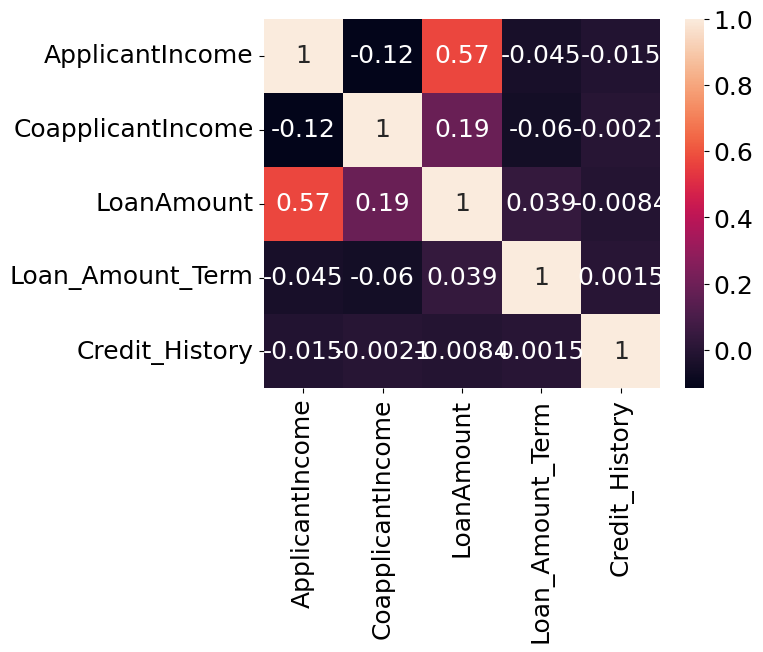

In [ ]:
import seaborn as sn

# correlation matrix
corr_matrix = df.iloc[:, 1:-1].corr()
print(corr_matrix)

# visualize
sn.heatmap(corr_matrix, annot=True)
plt.show()


# Preporcess Data

In [ ]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
# Detect outliers
def get_outliers(data, columns, nsd=7):
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        mean = elements.mean()
        sd = elements.std()
        # get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# assign data type and NA values, also check with outliers
def prepro(df,numimp,catimp):
      # drop ID column
      df=df.drop(['Loan_ID'],axis=1)

      # identify numeric/categorical features
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['Loan_Status'], axis=1).columns

      # Credit_History should be a categorical variable
      numeric_features=numeric_features.drop('Credit_History')
      categorical_features=categorical_features.insert(6, 'Credit_History') 
    
      # assign datatypes
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      df['Loan_Status'] = df['Loan_Status'].astype('category')   

      #identify and remove outliers for the numerical variables
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      # impute missing numerical values
      imputer = SimpleImputer(missing_values = np.nan, strategy = numimp)
      imputer = imputer.fit(df[numeric_features.tolist()])
      df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

      #impute missing categorical values. 
      imputercat = SimpleImputer(missing_values = np.nan, strategy = catimp)
      imputercat = imputercat.fit(df[categorical_features.tolist()])
      df[categorical_features.tolist()] = imputercat.transform(df[categorical_features.tolist()])
      df['Credit_History'] = df['Credit_History'].astype('category')   

      # features
      feat = df.loc[:, df.columns != 'Loan_Status']

      # label
      lab = df.Loan_Status

      # hot encode the categorical features
      feat = pd.get_dummies(feat)

      # re-code the response variable
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      # log transforation to househode income
      feat['Household_Income_log']=np.log(feat.ApplicantIncome + feat.CoapplicantIncome)

      # Append new feature to our numerical features
      numeric_features=numeric_features.insert(len(numeric_features),'Household_Income_log') 
      
      # Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

In [ ]:
# Call PREPROCESSING function and pass it the dataframe as well as the imputation strategies for (1) numerical and (2) categorical features
data = prepro(df,'median','most_frequent') 

# Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# Get numerical features
numeric_features = data[2]

# Verify that it worked
display(X.head())
display(y.head())
display(numeric_features)
display(f"Observations after Preprocessing: {len(X)}")

# check missing values
print(df.isnull().sum())

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log
0,5849.0,0.0,127.0,360.0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,0,1,8.674026
1,4583.0,1508.0,128.0,360.0,0,1,0,1,0,1,...,1,0,1,0,0,1,1,0,0,8.714568
2,3000.0,0.0,66.0,360.0,0,1,0,1,1,0,...,1,0,0,1,0,1,0,0,1,8.006368
3,2583.0,2358.0,120.0,360.0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,0,1,8.505323
4,6000.0,0.0,141.0,360.0,0,1,1,0,1,0,...,1,0,1,0,0,1,0,0,1,8.699515


0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: category
Categories (2, int64): [0, 1]

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Household_Income_log'],
      dtype='object')

'Observations after Preprocessing: 609'

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [ ]:
# output the clean file for R
from google.colab import files
df.to_csv('home_loan_cleaned.csv', encoding = 'utf-8-sig') 
files.download('home_loan_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Models

## Simple multiple linear regression

Start with fit all features in the regression

                            OLS Regression Results                            
Dep. Variable:            Loan_Status   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     11.48
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.49e-23
Time:                        21:19:56   Log-Likelihood:                -201.21
No. Observations:                 426   AIC:                             434.4
Df Residuals:                     410   BIC:                             499.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Text(103.9222222222222, 0.5, 'Actual label')

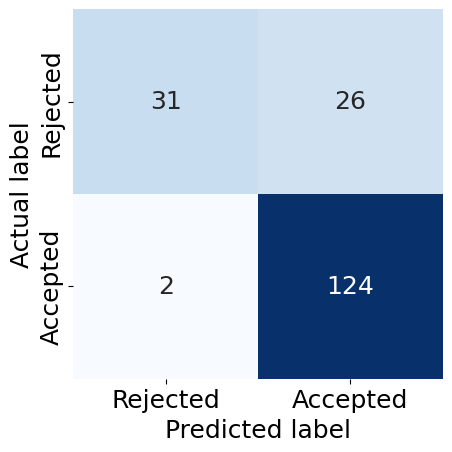

In [ ]:
# Import necessary packages
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X = sm.add_constant(X) # adding a constant
 
# Fit the model on the training set
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

print_model = model.summary()
print(print_model)


# Make predictions on the test set
X_test = sm.add_constant(X_test)
predictions = model.predict(X_test) > 0.5

# Calculate the test MSE
test_mse = mean_squared_error(y_test, predictions)

# Print the test MSE
print("Test MSE: {:.2f}".format(test_mse))

# Compute confusion matrix
mat = confusion_matrix(y_test, predictions)
labels = ['Rejected', 'Accepted']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')


In [ ]:
# Calculate accuracy
from sklearn import metrics

print("OLS")
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))

OLS
Accuracy: 0.8469945355191257
Precision: 0.8266666666666667
Recall: 0.9841269841269841


## LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Print the coefficients of the model
print(lasso_model.coef_)

# Predict the target variable for the test set
y_pred = lasso_model.predict(X_test) > 0.5

# Calculate the mean squared error on the test set
test_mse = mean_squared_error(y_test, y_pred)

# Print the test MSE
print("Test MSE: {:.2f}".format(test_mse))

# Calculate R2 score
test_r2 = r2_score(y_test, y_pred)
print("Test R2 score:", test_r2)

[ 0.00000000e+00  1.62579285e-06  1.12236627e-05 -4.59397752e-04
  7.73494215e-05  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
Test MSE: 0.32
Test R2 score: -0.47786131996658354


LASSO
Accuracy: 0.6830601092896175
Precision: 0.6868131868131868
Recall: 0.9920634920634921


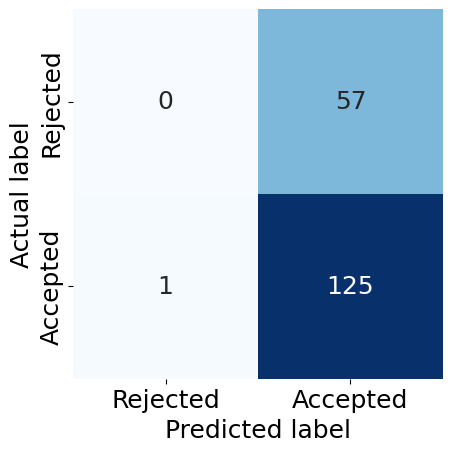

In [ ]:
# Compute confusion matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Rejected', 'Accepted']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

print("LASSO")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))